In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
import pandas as pd

train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')


In [3]:
train_df.head()

,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,69,Male,Heart Disease,1,2,1,Home Health Care,0
1,32,Female,COPD,2,13,2,Rehabilitation Facility,0
2,89,Male,Diabetes,1,7,1,Home,0
3,78,Male,COPD,9,2,2,Skilled Nursing Facility,0
4,38,Male,Diabetes,6,4,4,Rehabilitation Facility,0


In [4]:
test_df.head()

,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to
0,52,Male,Heart Disease,3,9,3,Home
1,47,Female,Diabetes,2,4,0,Skilled Nursing Facility
2,72,Female,Heart Disease,7,12,4,Home
3,18,Female,COPD,5,14,3,Home
4,32,Male,Heart Disease,9,2,4,Rehabilitation Facility


In [5]:
X_train=train_df.drop('readmitted',axis=1)
y_train= train_df['readmitted']
print(X_train.head())
print(y_train.head())

   age  gender primary_diagnosis  num_procedures  days_in_hospital  \
0   69    Male     Heart Disease               1                 2   
1   32  Female              COPD               2                13   
2   89    Male          Diabetes               1                 7   
3   78    Male              COPD               9                 2   
4   38    Male          Diabetes               6                 4   

   comorbidity_score              discharge_to  
0                  1          Home Health Care  
1                  2   Rehabilitation Facility  
2                  1                      Home  
3                  2  Skilled Nursing Facility  
4                  4   Rehabilitation Facility  
0    0
1    0
2    0
3    0
4    0
Name: readmitted, dtype: int64


In [6]:
test_df['readmitted'] = -1
combined = pd.concat([X_train, test_df], axis=0)


In [7]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['gender', 'primary_diagnosis', 'discharge_to']
encoder = LabelEncoder()

for col in categorical_cols:
    combined[col] = encoder.fit_transform(combined[col])


In [8]:
X_train_processed = combined[combined['readmitted'] != -1].drop('readmitted', axis=1)
X_test_processed = combined[combined['readmitted'] == -1].drop('readmitted', axis=1)


In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=350,        
    max_depth=10,             
    min_samples_split=5,      
    min_samples_leaf=3,       
    class_weight='balanced',  
    random_state=42
)

model.fit(X_train_processed, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=350, random_state=42)

In [10]:
test_predictions = model.predict(X_test_processed)
test_predictions

array([0, 0, 0, ..., 1, 0, 0])

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

train_preds = model.predict(X_train_processed)

conf_matrix = confusion_matrix(y_train, train_preds)
accuracy = accuracy_score(y_train, train_preds)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)


Confusion Matrix:
 [[3971   89]
 [ 131  809]]
Accuracy: 0.956


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_train, train_preds))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4060
           1       0.90      0.86      0.88       940

    accuracy                           0.96      5000
   macro avg       0.93      0.92      0.93      5000
weighted avg       0.96      0.96      0.96      5000



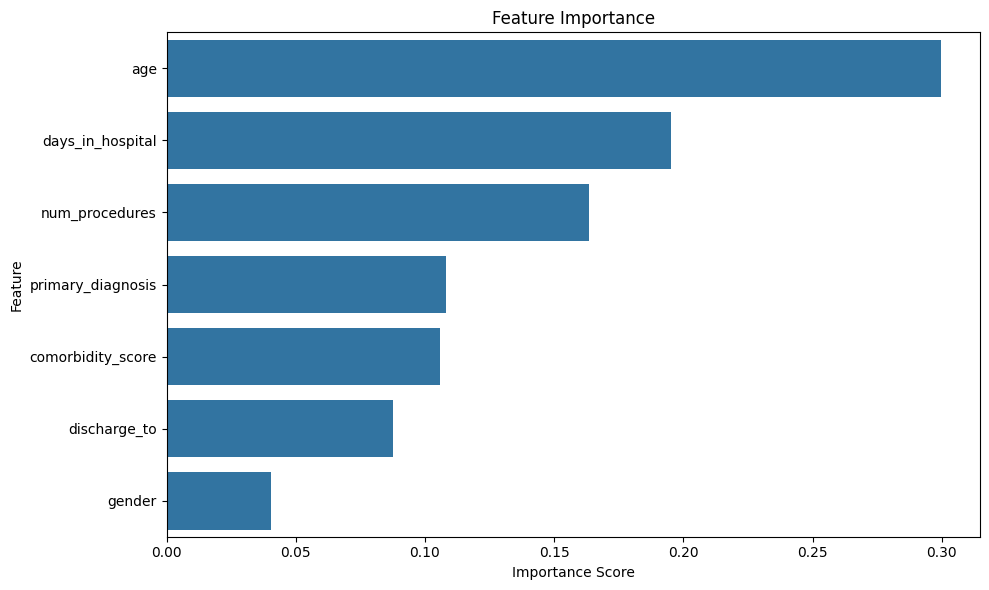

<Figure size 640x480 with 0 Axes>

In [21]:
importances = model.feature_importances_
features = X_train_processed.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
plt.savefig('static/feature-importance.png')


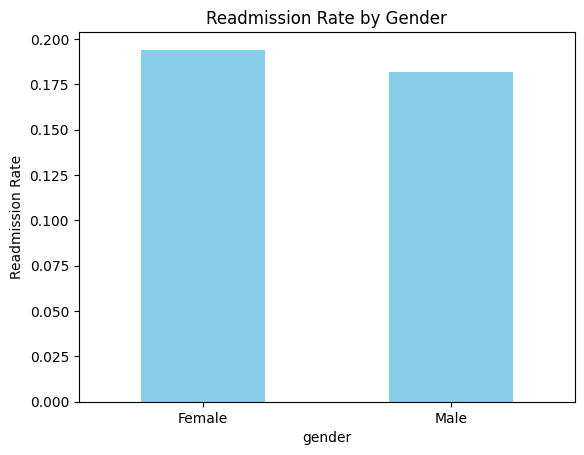

<Figure size 640x480 with 0 Axes>

In [19]:
readmitted_by_gender = train_df.groupby('gender')['readmitted'].mean()

readmitted_by_gender.plot(kind='bar', color='skyblue')
plt.title('Readmission Rate by Gender')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=0)
plt.show()
plt.savefig('static/Readmission-rate-by-gender.png')



In [15]:
num_unique_diagnoses = train_df['primary_diagnosis'].nunique()
print(f"Number of unique primary diagnoses: {num_unique_diagnoses}")


Number of unique primary diagnoses: 5


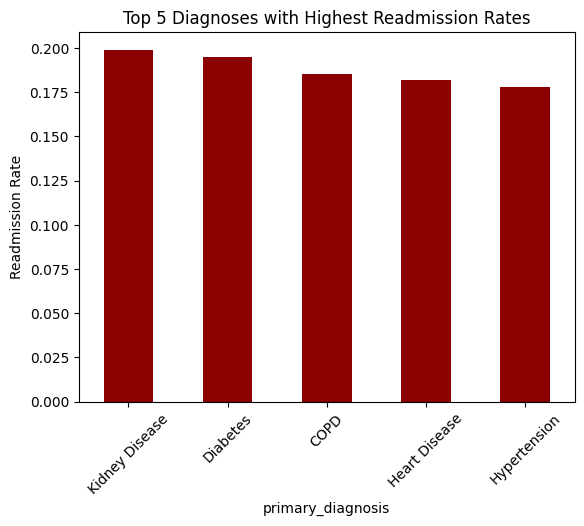

<Figure size 640x480 with 0 Axes>

In [18]:
readmitted_by_diag = train_df.groupby('primary_diagnosis')['readmitted'].mean().sort_values(ascending=False).head(5)

readmitted_by_diag.plot(kind='bar', color='darkRED')
plt.title('Top 5 Diagnoses with Highest Readmission Rates')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=45)
plt.show()
plt.savefig('static/diagnosis_chart.png')


In [17]:
output = test_df.drop(columns='readmitted')
output['readmitted_prediction'] = test_predictions
output.to_csv('readmission_predictions.csv', index=False)


In [23]:

import pickle
import os

os.makedirs('model', exist_ok=True)
with open('model/rf_model.pkl', 'wb') as f:
    pickle.dump(model, f)
